# Exploration Data Analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [2]:
# Import de la base de données
recipes = pd.read_csv("../data/RAW_recipes.csv")
recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


# Analyse des ingrédients

L'objectif est de construire 7 variables synthétiques a priori sur la base des ingrédients 

In [3]:
import ast

# Extraction de l'ensemble des ingrédients
ingredients = recipes['ingredients'].apply(ast.literal_eval).explode()
# ingredients_count = ingredients.value_counts()
ingredients = pd.unique(ingredients).tolist()

On calcule les coordonnées des ingrédients dans des embeddings.

In [4]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-mpnet-base-v2")

# sentences = ingredients.astype(str)
# sentences = sentences.tolist()

embeddings = model.encode(ingredients)
# embeddings = pd.DataFrame(embeddings)
# embeddings = embeddings.set_index(ingredients)


In [5]:
axes_phrases = {
    "sweet_savory": ("sweet dessert flavor", "savory meal flavor"),
    "spicy_mild": ("spicy hot food", "mild gentle flavor"),
    "lowcal_rich": ("low-calorie healthy food", "rich and fatty dish"),
    "vegetarian_meat": ("vegetarian food without meat", "meat-based dish"),
    "solid_liquid": ("solid food", "liquid food or drink"),
    "raw_processed": ("raw natural ingredient", "processed or prepared food"),
    "western_exotic": ("typical western food", "exotic or asian food"),
}

def axis_vector(model, pos_name, neg_name):
    return model.encode(pos_name) - model.encode(neg_name)

axis_vecs = {axe_name: axis_vector(model, pos_name, neg_name) 
             for axe_name, (pos_name, neg_name) in axes_phrases.items()}

axes_names = list(axis_vecs.keys())
axis_matrix = np.stack(list(axis_vecs.values()))  # shape (n_axes, dim embeddings)

# Normaliser embeddings et axes (pour cosinus)
emb_norm = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
axis_norm = axis_matrix / np.linalg.norm(axis_matrix, axis=1, keepdims=True)

# Produit matriciel pour cosinus
# result[i, j] = cosine(ingredient i, axis j)
cos_sim_matrix = np.dot(emb_norm, axis_norm.T)   # shape (n_ingredients, n_axes)

scores_df = pd.DataFrame(cos_sim_matrix, index=ingredients, columns=axes_names)


<BarContainer object of 7 artists>

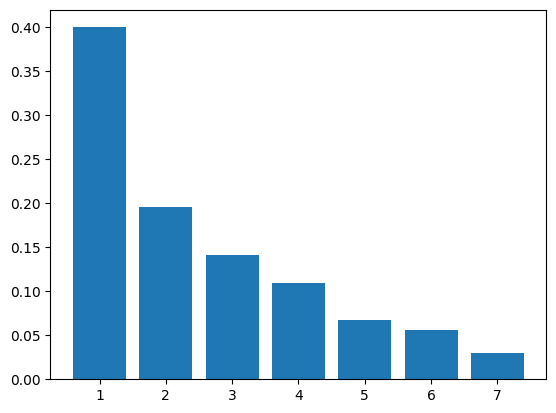

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# PCA sur les données centrées et réduites de scores_df

scaler = StandardScaler()
scores_scaled = scaler.fit_transform(scores_df)
scores_scaled = pd.DataFrame(scores_scaled, index=scores_df.index, columns=scores_df.columns)

pca = PCA(n_components=len(axes_names))
pca = pca.fit(scores_scaled)

# Diagramme en bâtons des valeurs propres
plt.bar(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)



# plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker="o") 
# n_axes = np.sum(pca.explained_variance_ratio_ > 1/len(cluster_labels))

On réalise la CAH complète dans un premier temps (sans coupure de l'arbre) de façon à pouvoir déterminer un seuil pertinent ensuite

In [13]:
# Scatter plot des deux premières composantes principales
import plotly.express as px

pca_4d = pca.transform(scores_scaled)[:, :4]
pca_4d = pd.DataFrame(pca_4d, index=scores_scaled.index, columns=["Dim1", "Dim2", "Dim3", "Dim4"])


# Scatterplot interactif
fig = px.scatter(
    pca_4d,
    x="Dim1",
    y="Dim2",
    hover_name=pca_4d.index,   # Le label s’affiche au survol
    title="Scatterplot interactif avec hover"
)
fig.show()





In [ ]:
from sklearn.cluster import AgglomerativeClustering

# distance_threshold=0 pour obtenir l'arbre complet.
# metric et linkage adaptés aux embeddings de phrases

cah = AgglomerativeClustering(
	distance_threshold=0,
	n_clusters=None,
	metric="cosine",
	linkage="average"
)
cah = cah.fit(pca_4d)

ingredients_df = pd.DataFrame({
    "name": ingredients,
    "cluster": cah.labels_
})


In [ ]:
# Pour déterminer le seuil de coupure, on explicite la façon dont l'arbre regroupe les
# ingrédients à chaque étape 

def build_linkage_table(
    cah: AgglomerativeClustering,
    ingredients_df: pd.DataFrame
) -> pd.DataFrame:
    """
    Construit une table décrivant les fusions successives de la CAH.

    Args:
        cah (AgglomerativeClustering): Modèle de clustering hiérarchique entraîné.
        ingredients_df (pd.DataFrame): DataFrame avec au moins deux colonnes :
            - 'name' : le nom de chaque ingrédient (indexé ou non)
            - 'cluster' : le cluster associé à chaque ingrédient

    Returns:
        pd.DataFrame: Table des fusions successives avec noms et distances.
    """
    # --- Construction de la structure de base (les fusions successives)
    linkage = pd.DataFrame(
        cah.children_,
        columns=["left_son", "right_son"]
    )
    linkage["parent"] = linkage.index + len(ingredients_df)
    linkage["distance"] = cah.distances_

    # --- Préparer la table des ingrédients (avec index explicite)
    if "name" not in ingredients_df.columns:
        ingredients_df = ingredients_df.reset_index(names="name")

    # --- Fusionner les noms et clusters des deux "fils"
    linkage = (
        linkage
        .merge(ingredients_df[["name", "cluster"]],
               how="left", left_on="left_son", right_index=True)
        .rename(columns={"name": "left_name", "cluster": "left_cluster"})
        .merge(ingredients_df[["name", "cluster"]],
               how="left", left_on="right_son", right_index=True)
        .rename(columns={"name": "right_name", "cluster": "right_cluster"})
    )

    return linkage

linkage = build_linkage_table(cah, ingredients_df)


<Axes: >

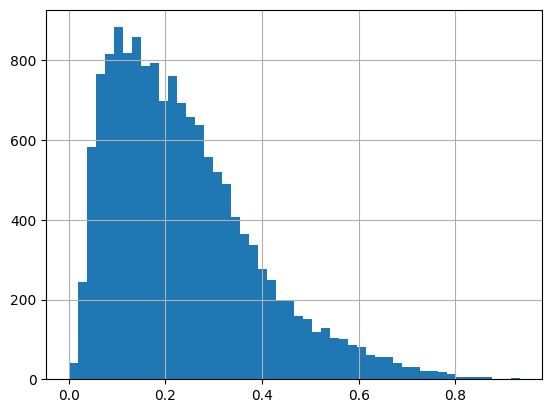

In [9]:
# Histogramme des distances
linkage.distance.hist(bins=50)

On peut proposer, avec le critère du coude, un seuil à 0.5. On se propose de vérifier empiriquement la pertinence du critère.

In [10]:
def cluster_labeling(data):
    """Chaque regroupement est étiqueté dans "parent name" par l'ingrédient le plus fréquent 
    (fréquence elle-même notée dans "parent freq")
    l'étiquette et la fréquence de l'ingrédient le plus fréquent dans chacun des deux fils sont également notés"""
    
    for i in range(len(data)):
        if not np.isnan(data.at[i, "rs cluster"]): # Si le fils droit est une feuille
            data.at[i, "rs cluster name"] = data.at[i, "rs name"]
            data.at[i, "rs freq"] = ingredients_count[data.at[i, "rs name"]]
        else: # Si le fils droit est un cluster, on en récupère le nom et la fréquence à la ligne où il a été défini comme parent
            data.at[i, "rs cluster name"] = data.loc[data["parent"] == data.at[i, "right son"], "parent name"].item()
            data.at[i, "rs freq"] = data.loc[data["parent"] == data.at[i, "right son"], "parent freq"].item()

        if not np.isnan(data.at[i, "ls cluster"]):
            data.at[i, "ls cluster name"] = data.at[i, "ls name"]
            data.at[i, "ls freq"] = ingredients_count[data.at[i, "ls name"]]
        else:
            data.at[i, "ls cluster name"] = data.loc[data["parent"] == data.at[i, "left son"], "parent name"].item()
            data.at[i, "ls freq"] = data.loc[data["parent"] == data.at[i, "left son"], "parent freq"].item()
        
        # Etiquetage du noeud parent par l'ingrédient le plus fréquent
        if data.at[i, "rs freq"] >= data.at[i, "ls freq"]:
            data.at[i, "parent name"] = data.at[i, "rs cluster name"]
            data.at[i, "parent freq"] = data.at[i, "rs freq"]
        else:
            data.at[i, "parent name"] = data.at[i, "ls cluster name"]
            data.at[i, "parent freq"] = data.at[i, "ls freq"]
    return data

linkage = cluster_labeling(linkage)


In [11]:
threshold = 0.50
linkage.loc[linkage['distance'] > 1.1 * threshold, ["distance", "ls cluster name", "rs cluster name"]].head(20)

,distance,ls cluster name,rs cluster name
14245,0.550088,bisquick,ready-made bruschetta
14246,0.550099,ribbon,cheesecloth
14247,0.550466,frozen blackberrie,frozen petits pois
14248,0.550868,jimmy dean breakfast skillets,morningstar farms meal starters grillers recip...
14249,0.551212,dried chamomile,chablis
14250,0.551248,angel food cake,icing sugar
14251,0.551285,cachaca,blue curacao
14252,0.551821,tea bags,tea
14253,0.552659,umeboshi vinegar,sake
14254,0.552759,low-calorie bread,bread


In [12]:
linkage.loc[linkage['distance'] < 0.9 * threshold, ["distance", "ls cluster name", "rs cluster name"]].tail(20)

,distance,ls cluster name,rs cluster name
13445,0.448202,heinz salad cream,heavy cream
13446,0.448416,seafood seasoning,poultry seasoning
13447,0.448427,mexican blend cheese,velveeta cheese
13448,0.448541,orange jell-o,unflavored gelatin
13449,0.448590,ground lamb,lamb backstraps
13450,0.448650,refrigerated biscuits,biscuit mix
13451,0.448719,accent seasoning,cajun seasoning
13452,0.448893,sloes,swede
13453,0.448903,ham knuckle,lamb shanks
13454,0.449209,salt,canning salt


In [13]:
model_cut = AgglomerativeClustering(
	distance_threshold=threshold,
	n_clusters=None,
	metric="cosine",
	linkage="average"
)
model_cut = model_cut.fit(embeddings)
print(model_cut.n_clusters_)

1023


In [14]:
ingredients_df = pd.DataFrame(ingredients)
ingredients_df['cluster'] = model_cut.labels_
ingredients_df = ingredients_df.rename(columns = {0 : 'name'})

# Etiquetage des clusters
temp = pd.merge(ingredients_df, ingredients_count, how="left", left_on="name", right_on="ingredients")
# on récupère les index des ingrédients les plus fréquents par cluster
idx_max = temp.groupby("cluster")["count"].idxmax()

cluster_labels = temp.loc[idx_max, ["name", "cluster"]]
cluster_labels = cluster_labels.rename(
	columns={"name": "cluster label"}
)
ingredients_df = pd.merge(ingredients_df, cluster_labels, on="cluster")

<Axes: >

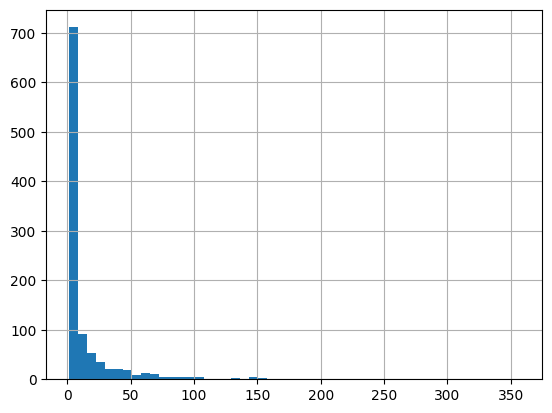

In [ ]:
# Distribution des tailles de clusters
ingredients_df['cluster label'].value_counts().hist(bins=50)
# ingredients_df.loc[ingredients_df['cluster label'] == "semi-sweet chocolate chips", "name"]

In [15]:
# On ajoute les étiquettes de clusters aux recettes
ingredients_by_recipe = pd.DataFrame(
	recipes['ingredients'].apply(ast.literal_eval).explode()
)
ingredients_by_recipe["id_recipe"] = ingredients_by_recipe.index.to_list()

ingredients_by_recipe = pd.merge(
	ingredients_by_recipe,
	ingredients_df,
	left_on="ingredients",
	right_on="name"
)



In [19]:
# Taille des clusters
ingredients_by_recipe['cluster label'].value_counts()

cluster label
salt             125331
pepper           104465
sugar             91055
olive oil         78881
onion             78344
                  ...  
garden trowel         1
terrapins             1
rumpleminze           1
cushaw                1
nepitella             1
Name: count, Length: 1023, dtype: int64

In [ ]:
# Suppression dans ingrédients_by_recipe des ingrédients dont les clusters sont trop petits
min_cluster_size = 50
cluster_sizes = ingredients_by_recipe['cluster label'].value_counts()
large_clusters = cluster_sizes[cluster_sizes >= min_cluster_size].index
ingredients_by_recipe = ingredients_by_recipe[
	ingredients_by_recipe['cluster label'].isin(large_clusters)
]

# Suppression dans cluster_labels des clusters trop petits
cluster_labels = cluster_labels[
    cluster_labels['cluster label'].isin(large_clusters)
]

# numéroter les lignes de 1 à len(cluster_labels) dans l'ordre des lignes, sans modifier l'index
cluster_labels['cluster'] = np.arange(1, len(cluster_labels) + 1)

In [23]:
cooc = np.zeros((len(cluster_labels), len(cluster_labels)), int)
index_map = {label: i for i, label in enumerate(cluster_labels["cluster label"])}

for recipe in range(len(recipes)):

    ings_recipe = ingredients_by_recipe.loc[ingredients_by_recipe["id_recipe"]==recipe, "cluster label"]

    for i, ing_recipe_h in enumerate(ings_recipe):
        for j, ing_recipe_v in enumerate(ings_recipe):
            cooc[index_map[ing_recipe_h], index_map[ing_recipe_v]] += 1

log_cooc = np.log1p(cooc)


In [30]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# ACP sur la matrice coocurrence 
pca = PCA(n_components=6)
X_proj = pca.fit_transform(log_cooc)  

# X_proj = coordonnées des ingrédients dans le plan factoriel
coords = pd.DataFrame(X_proj, columns=['Dim1', 'Dim2', 'Dim3', 'Dim4', 'Dim5', 'Dim6'])
coords['cluster'] = cluster_labels['cluster'].to_numpy()
coords = pd.merge(coords, cluster_labels, on="cluster", how="left")

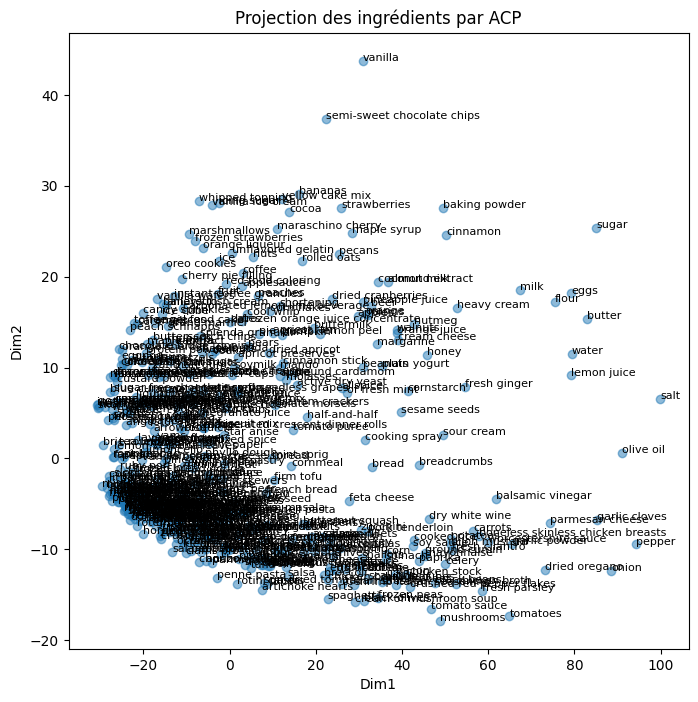

In [35]:
plt.figure(figsize=(8,8))
plt.scatter(coords['Dim1'], coords['Dim2'], alpha=0.5)

# si tu veux annoter les points
for i, row in coords.iterrows():
    plt.text(row['Dim1'], row['Dim2'], row['cluster label'], fontsize=8)

plt.xlabel("Dim1")
plt.ylabel("Dim2")
plt.title("Projection des ingrédients par ACP")
plt.show()

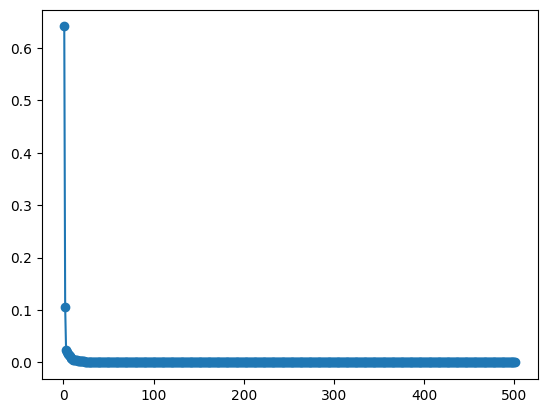

In [ ]:
pca = PCA()
pca = pca.fit(log_cooc)

plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker="o") 
n_axes = np.sum(pca.explained_variance_ratio_ > 1/len(cluster_labels))


In [39]:
# Pour chaque recette dans recipes, on ajoute les coordonnées moyennes des ingrédients sur les trois premiers axes factoriels
def get_recipe_coords(recipe_ingredients):
    """Calcule les coordonnées moyennes des ingrédients d'une recette sur les trois premiers axes factoriels"""
    coords_recipe = coords[coords['cluster label'].isin(recipe_ingredients)]
    if len(coords_recipe) == 0:
        return pd.Series([np.nan, np.nan, np.nan], index=['Dim1', 'Dim2', 'Dim3'])
    else:
        return pd.Series(coords_recipe[['Dim1', 'Dim2', 'Dim3']].mean(), index=['Dim1', 'Dim2', 'Dim3'])
    
recipes_coords = recipes['ingredients'].apply(ast.literal_eval).apply(get_recipe_coords)


